<a href="https://colab.research.google.com/github/AntNeedsHelp/ExplainableAI/blob/main/cleaned_CNN_pneumoniaMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117 &> /dev/null
!pip3 install medmnist &> /dev/null

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.utils.data as data


from tqdm import tqdm


import medmnist
from medmnist import INFO, Evaluator

In [3]:
data_flag = 'pneumoniamnist'

download = True

NUM_EPOCHS = 3
BATCH_SIZE = 4
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [22]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
trainloader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


classes = [
    "Negative",
    "Positive",
]


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


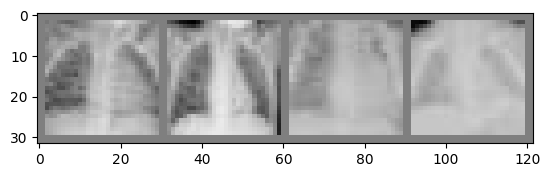

Positive Positive Positive Positive


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F


# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net().to(device)


Using cuda device


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer, training_loss, print_size=1):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y = torch.squeeze(y)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % print_size == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            training_loss.append(loss)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn, test_accuracy):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = torch.squeeze(y)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_accuracy.append(100*correct)
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.5f}%, Avg loss: {test_loss:>8f} \n")

ACTUAL TRAINING LOOP

In [10]:
epochs = 10

training_loss = []
testing_accuracy = []

for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer, training_loss, 1000)
    test(testloader, model, loss_fn, testing_accuracy)
print("Done!")
%time

Done!
CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 5.25 µs


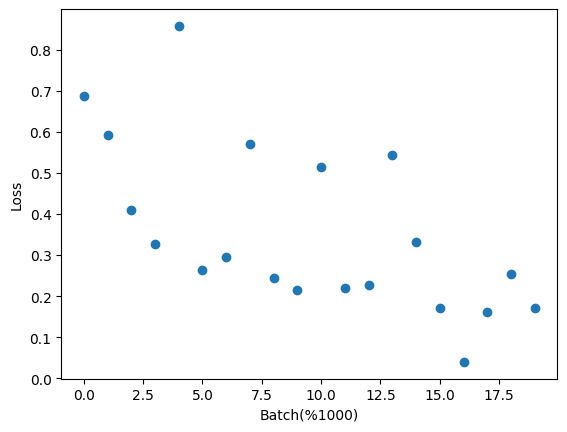

In [11]:

plt.plot(training_loss, 'o')
plt.ylabel("Loss")
plt.xlabel("Batch(%1000)")
plt.show()

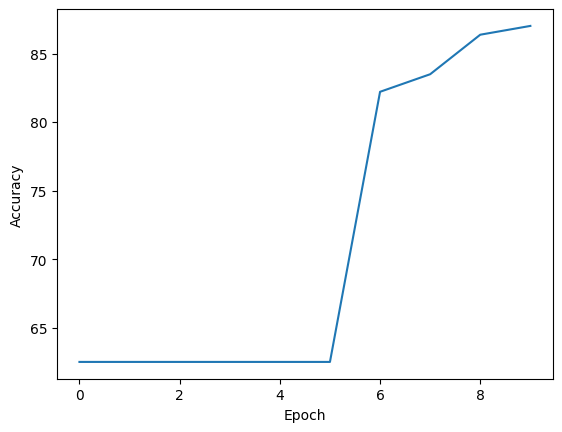

In [12]:
plt.plot(testing_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [13]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [14]:
model = Net().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [15]:
def normalize(pred):
  pred = np.log(np.exp(pred)/np.sum(np.exp(pred)))
  return pred

ORIGINAL IMAGE:


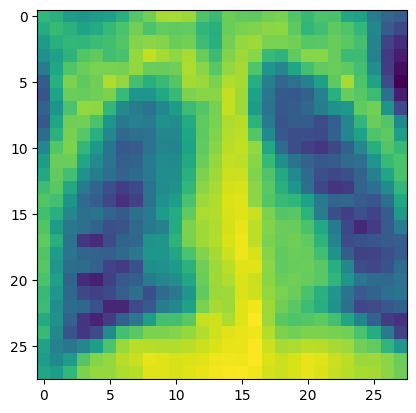

EFFECT ON 'TRUE':


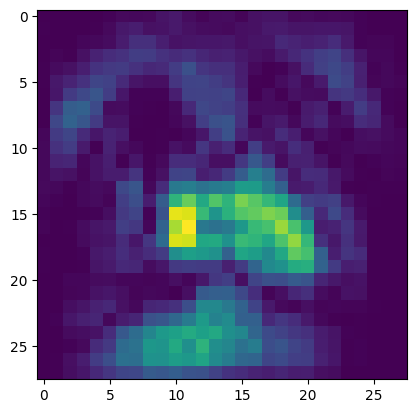

EFFECT ON 'FALSE':


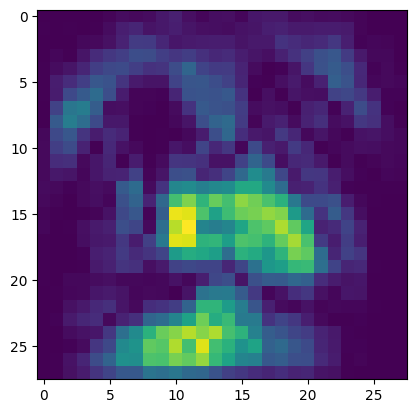

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [43]:
classes = [
    0, #negative
    1, #positive
]

model.eval()


def get_pred(x, print_val = True):
  model.eval()
  with torch.no_grad():
      x = x.to(device)
      pred = normalize(model(x[None]).cpu().numpy())

      #normalize pred ^^^^
      predicted, actual = classes[pred[0].argmax(0)], classes[y[0]]
      if print_val:
        print("PRED:",pred)

        print(f'Predicted: "{predicted}", Actual: "{actual}"')
  model.train()
  return pred, (predicted, actual)




def pixel_strength(image_index, show=False):

  #get image at index from dataset
  x, y = test_dataset[image_index][0], test_dataset[image_index][1]

  #initialize arrays
  pred_array = np.zeros((x.shape[1], x.shape[2], 2)) #array of prediction values (true_float, false_float) for each pixel when it gets set to 0
  true_array = np.zeros((x.shape[0],x.shape[1], x.shape[2])) #array of difference of true_float prediction values between original values and values when pixel set to 0; used for visualization
  false_array = np.zeros((x.shape[0],x.shape[1], x.shape[2])) #array of difference of false_float prediction values between original values and values when pixel set to 0; used for visualization

  #original pred values
  original_pred = get_pred(x, False)[0]

  #iterate through every pixel to see its effect on the prediction
  for i in range(x.shape[1]):
    for j in range(x.shape[2]):
      orig_value = x[0,i:i+2,j:j+2].clone().detach() #save original value of pixel
      x[0,i:i+2,j:j+2] = 0 #set indicated pixel to value 0
      pred_array[i,j,:] = get_pred(x, False)[0]

      pred_vals, bool_vals = get_pred(x, False)

      pred_array[i,j,:] = pred_vals

      false_array[0,i,j] = abs(original_pred[0][0] - pred_vals[0][0]) #store how much the pixels "false" prediction changed
      true_array[0,i,j] = abs(original_pred[0][1] - pred_vals[0][1]) #sstore how much the pixels "true" prediction changed


      x[0,i:i+2,j:j+2] = orig_value #return pixel to original value



  if show:
    #VISUALIZE EFFECT OF EACH PIXEL
    true_image = torch.from_numpy(true_array)
    false_image = torch.from_numpy(false_array)

    print("ORIGINAL IMAGE:")
    imshow(x)
    print("EFFECT ON 'TRUE':")
    imshow(true_image)
    print("EFFECT ON 'FALSE':")
    imshow(false_image)

  return true_array #return true_array for use in other functions

pixel_strength(2, True)

model.train()



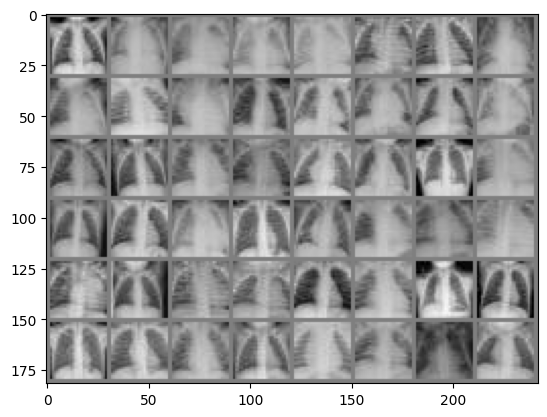

[(0, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, 0), (0, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (1, 0), (0, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, 0), (1, 0), (1, 0), (0, 0), (1, 0), (1, 0), (0, 0), (0, 0), (1, 0), (1, 0), (0, 0), (1, 0), (1, 0), (1, 0), (0, 0)]


In [28]:
#SHOW PREDICTIONS FOR MANY IMAGES

def predict_many(start, end, change=1):
  img_arr = np.zeros(((end-start),1,28,28))

  predss = []
  for index in range(start, end, change):
    x, y = test_dataset[index][0], test_dataset[index][1]
    actual_val, pred_val = get_pred(x, False)[1]
    img_arr[(index-start)] = x
    predss.append((actual_val, pred_val))

  img_arr = torch.tensor(img_arr)
  imshow(torchvision.utils.make_grid(img_arr))
  print(predss)

predict_many(3,51)

In [35]:
def overlay(img, over):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.imshow(np.transpose(over, (1, 2, 0)))
    plt.show()

In [58]:
def show_on_image(image_index, displayed = 100):

  x, y = test_dataset[image_index][0], test_dataset[image_index][1] #get image from dataset

  true_array = pixel_strength(image_index)

  x_rgb = np.zeros((4,x.shape[1], x.shape[2]))

  x_rgb[0]= x[0]
  x_rgb[1] = x[0]
  x_rgb[2] = x[0]
  x_rgb[3] = 1

  true_rgb = np.zeros((4,x.shape[1], x.shape[2]))

  true_rgb[0]= true_array[0]*20
  true_rgb[1] = 0
  true_rgb[2] = 0
  true_rgb[3] = 0.5


  x_rgb_image = torch.from_numpy(x_rgb)
  print("ORIGINAL IMAGE:")
  imshow(x_rgb_image)

  true_rgb = torch.from_numpy(true_rgb)



  sorted_true = np.sort(true_rgb[0], axis=None) #sort array in terms of pixel strength


  num_disp = displayed

  minimum_displayed = sorted_true[sorted_true.size-num_disp] #find the value of pixel strength at index 'displayed'


  displayed_array = np.copy(true_rgb)
  displayed_array[displayed_array < minimum_displayed] = 0 # if pixel values are lower than the 'displayed'th value, blank them


  displayed_array[displayed_array >= minimum_displayed] = 1 #if pixel values are higher than the 'displayed'th value, give them maximum strength


  displayed_array[3][displayed_array[0] < minimum_displayed] = 0 # if pixel values are lower than the 'displayed'th value, give them opacity 0

  displayed_array[3][displayed_array[0] >= minimum_displayed] = 0.5 # if pixel values are higher than the 'displayed'th value, give them opacity 0.5

  print('TOP', displayed, 'PIXELS:')
  imshow(torch.from_numpy(displayed_array))



  print('WHERE PNEUMONIA IS LIKELY TO BE:')
  overlay(x_rgb, displayed_array)

ORIGINAL IMAGE:


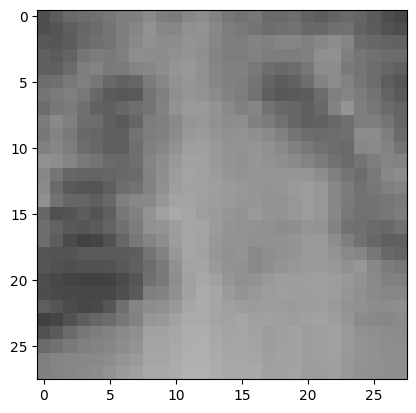

TOP 100 PIXELS:


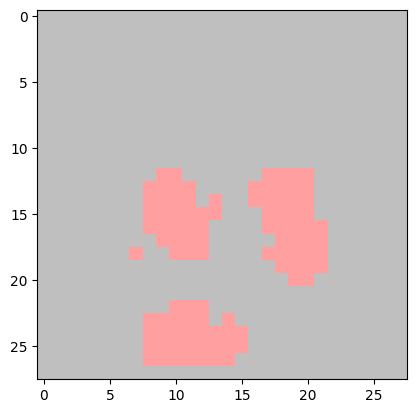

WHERE PNEUMONIA IS LIKELY TO BE:


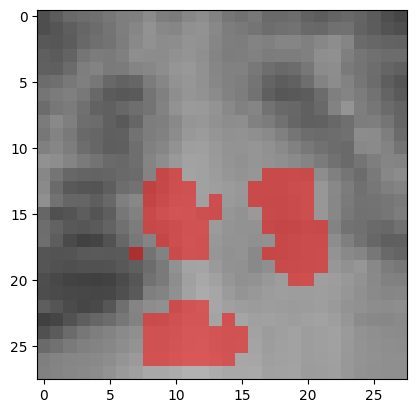

In [60]:
show_on_image(422)